# homework 3
me when no template :'( 

In [116]:
# imports for the script
from sklearn.datasets import load_diabetes, make_classification
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, f1_score, balanced_accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [117]:
# the seed cell.
seed = 42

### 1. Model Selection for Decision Tree Regression

In [118]:
# load dataset from sklearn
diabetes = load_diabetes()
X = diabetes.data

y = diabetes.target

# print(f"X shape: {X.shape}")
# print(f"y shape: {y.shape}")
# print(diabetes.feature_names)
# print(diabetes.target)

In [119]:
# split data into training, validation and test sets

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=seed, shuffle=True
)

In [120]:
max_depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
min_samples_split = [2, 3, 4, 5, 6, 7, 8, 9, 10]
grid = []

for i in max_depth:
    for j in min_samples_split:
        grid.append((i, j))


In [121]:
# finding the best hyperparameters
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
heighest_score = np.inf
best_params = None

for max_d, min_s in grid:
    val_scores = []
    for train_index, val_index in kfold.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        model = DecisionTreeRegressor(max_depth=max_d, min_samples_split=min_s, random_state=seed)
        model.fit(X_train_fold, y_train_fold)
        val_score = mean_squared_error(y_val_fold, model.predict(X_val_fold))
        val_scores.append(val_score)
    mean = np.mean(val_scores)
    # print(f"Mean: {mean}")
    if mean < heighest_score:
        heighest_score = mean
        best_params = (max_d, min_s)

print(heighest_score)
print(f"Best hyperparameters: {best_params}")

4028.034388364361
Best hyperparameters: (2, 2)


In [122]:
# finding the best hyperparameters using GridSearchCV
gscv = GridSearchCV(
    DecisionTreeRegressor(), 
    param_grid={'max_depth': max_depth, 'min_samples_split': min_samples_split}, 
    cv=kfold, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1
    )

gscv.fit(X_train, y_train)
print(gscv.best_params_)

{'max_depth': 2, 'min_samples_split': 2}


In [123]:
# testing the model with the hyperparameters found
model = DecisionTreeRegressor(max_depth=best_params[0], min_samples_split=best_params[1])
model.fit(X_train, y_train)
test_score = mean_squared_error(y_test, model.predict(X_test))
print(f"Test score: {test_score}")

Test score: 3735.4996177389003


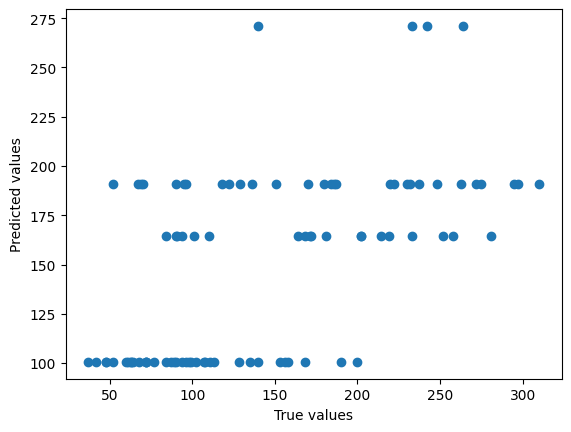

In [124]:
plt.scatter(y_test, model.predict(X_test))

plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.show()

In [125]:
# testing the model with the hyperparameters found
model = DecisionTreeRegressor(max_depth=100, min_samples_split=2)
model.fit(X_train, y_train)
test_score = mean_squared_error(y_test, model.predict(X_test))
print(f"Test score: {test_score}")

Test score: 4923.011235955056


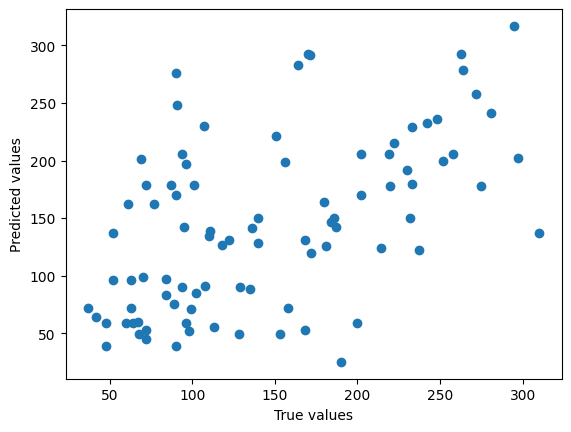

In [126]:

plt.scatter(y_test, model.predict(X_test))


plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.show()

How does the test MSE compare for the two methods (k-fold cross-validation versus a fixed
validation dataset)?

- not that much worse ngl

### 2. Unbalanced Datasets and Model Selection
*Using a synthetic dataset*

In [127]:
# Creating dataset

ratio = [0.6, 0.75, 0.9, 0.95, 0.98, 0.99]
datasets = []

for r in ratio:
    dataset = make_classification(
        n_samples=1000, 
        n_features=20,
        weights=[r], # nclasses - 1
        n_classes=2,
        random_state=seed
        )
    
    datasets.append(dataset)

    # print (f"Dataset with ratio {r}")
    # print (f"X shape: {X.shape}")
    # print (f"y shape: {y.shape}")
    # print ()

In [128]:
# finding the best k_near neighbor value
ks = range(1, 31)
metric = 'minkowski' # 'chebyshev' 'manhattan' 'minkowski'
weights = 'uniform' # 'distance' 'uniform'

best_ks = []

for i in range(len(datasets)): # iterating through the datasets
    X, y = datasets[i]
    X_train, X_val_test, y_train, y_val_test = train_test_split(
        X, y, train_size=0.7, random_state=seed, shuffle=True
        )
    X_val, X_test, y_val, y_test = train_test_split(
        X_val_test, y_val_test, train_size=0.5, random_state=seed, shuffle=True
        )

    val_scores = []
    for k in ks: # iterating through the different k_near neighbor values
        clf = KNeighborsClassifier(
            n_neighbors=k, 
            metric=metric, 
            weights=weights
            )
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_val)
        val_scores.append(accuracy_score(y_val, y_pred))

    best_ks.append(ks[np.argmax(val_scores)])

print(best_ks)

[25, 26, 2, 2, 2, 2]


$F1 = 2 \cdot \frac{\text{ Precision } \cdot \text{ Recall }}{\text{ Precision } + \text{ Recall }}$

In [129]:
# testing the model with k value
accuracies = []
balanced_accuracies = []
f1_scores = []
confusion_matrices = []


for i in range(len(datasets)):
    X, y = datasets[i]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=0.7, random_state=seed, shuffle=True
        )
    
    clf = KNeighborsClassifier(
        n_neighbors=best_ks[i], 
        metric=metric, 
        weights=weights
        )
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    # different metrics
    accuracies.append( accuracy_score(y_test, y_pred) )
    balanced_accuracies.append( balanced_accuracy_score(y_test, y_pred) )
    f1_scores.append( f1_score(y_test, y_pred, pos_label=0) )
    confusion_matrices.append( confusion_matrix(y_test, y_pred) )

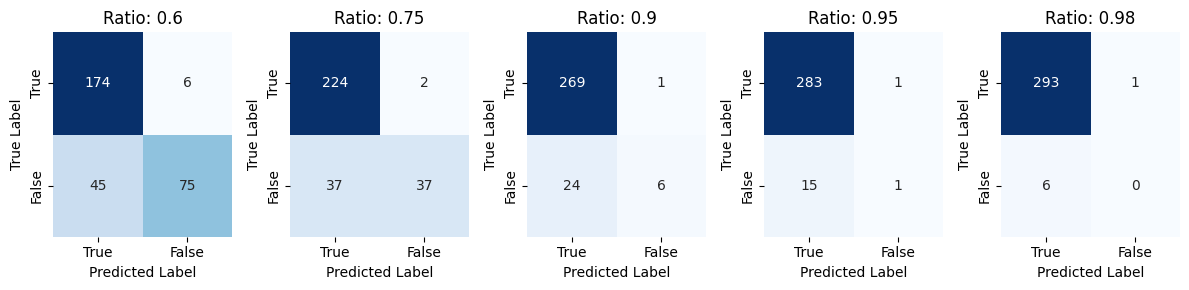

In [130]:
# confusion matrix plot
# TP, FN
# FP, TN
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for i, ax in enumerate(axes):
    sns.heatmap(confusion_matrices[i], fmt='g', cmap='Blues', annot=True,
                xticklabels=['True', 'False'], yticklabels=['True', 'False'], cbar=False, ax=ax)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title(f"Ratio: {ratio[i]}")

plt.tight_layout()
plt.show()

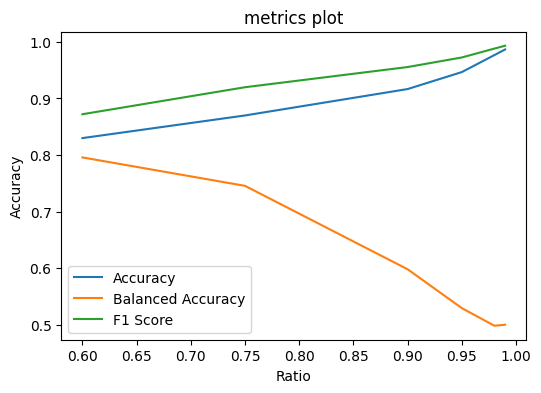

In [131]:
# different metrics plot
fig, ax = plt.subplots( figsize=(6, 4) )
ax.plot(ratio, accuracies, label='Accuracy')

# if the classes are different sizes, the balanced accuracy weighs the classes equally
ax.plot(ratio, balanced_accuracies, label='Balanced Accuracy')
ax.plot(ratio, f1_scores, label='F1 Score')
ax.set_title('metrics plot')

ax.set_xlabel('Ratio')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()

*Using a predefined dataset*

In [132]:
# pickle.

X, y = np.load('custom_unbalanced_dataset.pickle', allow_pickle=True)
print(X.shape)
print(y.shape)

(10000, 2)
(10000,)


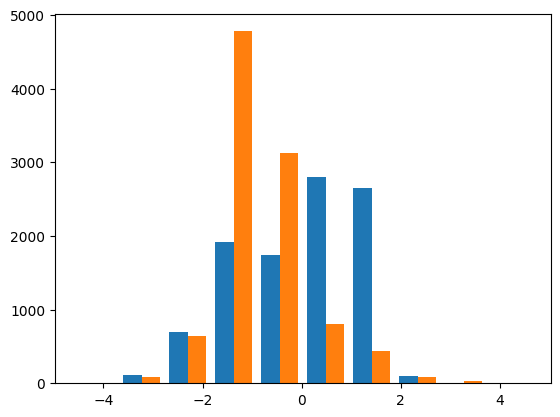

In [133]:
# plot histogram
plt.hist(X)
plt.show()

In [134]:
# split data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=seed, shuffle=True
)

In [135]:
def foo () -> float:
    kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

    k_scores = []
    k2_scores = []
    k3_scores = []

    for k in ks:
        f1_scores = []
        acc_scores = []
        bal_acc_scores = []
        for train_index, test_index in kfold.split(X_train, y_train):
            X_train_fold, X_val_fold = X_train[train_index], X_train[test_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[test_index]

            clf = KNeighborsClassifier(
                n_neighbors=k, 
                metric=metric, 
                weights=weights
                )
            clf.fit(X_train_fold, y_train_fold)
            y_pred_fold = clf.predict(X_val_fold)

            f1_scores.append(f1_score(y_val_fold, y_pred_fold, pos_label=0))
            acc_scores.append(accuracy_score(y_val_fold, y_pred_fold))
            bal_acc_scores.append(balanced_accuracy_score(y_val_fold, y_pred_fold))
        k_scores.append(np.mean(f1_scores))
        k2_scores.append(np.mean(acc_scores))
        k3_scores.append(np.mean(bal_acc_scores))

    print(f"Best f1 score: {np.max(k_scores):.3f}, with k={ks[np.argmax(k_scores)]}")
    print(f"Best acc score: {np.max(k2_scores):3f}, with k={ks[np.argmax(k2_scores)]}")
    print(f"Best bal acc score: {np.max(k3_scores):.3f}, with k={ks[np.argmax(k3_scores)]}")

    return ks[np.argmax(k_scores)]

In [136]:
# i think the best metric would be the f1 score, since it
# is a binary classification problem,
# and the the focus is on precision and recall
best_k = foo()

Best f1 score: 0.985, with k=15
Best acc score: 0.973125, with k=9
Best bal acc score: 0.926, with k=11


In [137]:
# testing the model using the best k value and the f1 score metric

clf = KNeighborsClassifier( n_neighbors=best_k, metric=metric, weights=weights )
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
f1 = f1_score(y_test, y_pred, pos_label=0)
con_mat = confusion_matrix(y_test, y_pred)
print (f"best k: {best_k}")
print (f"f1 score: {f1}")
print (f"confusion matrix:\n {con_mat}")

best k: 15
f1 score: 0.9856194690265486
confusion matrix:
 [[1782   25]
 [  27  166]]


In [138]:
# f1 score
p = 1782/(1782+27)
r = 1782/(1782+25)

print(f"F1 score: {2*(p*r)/(p+r):.3f}")


F1 score: 0.986
